# Scaling up

In [ ]:
# seisbench planetary computer environment
!mamba env create --quiet -f ../seisbench-testing/environment.yml

In [1]:
import pandas as pd
import obspy 
import obsplus
from obspy.clients.fdsn import Client

## Open catalog parquet files

In [2]:
%%time

dfP = pd.read_parquet('https://github.com/scottyhq/quakeflow-examples/raw/main/XO_2018_10_picks.parquet')
dfE = pd.read_parquet('https://github.com/scottyhq/quakeflow-examples/raw/main/XO_2018_10_events.parquet')
dfA = pd.read_parquet('https://github.com/scottyhq/quakeflow-examples/raw/main/XO_2018_10_arrivals.parquet')
dfS = pd.read_parquet('https://github.com/scottyhq/quakeflow-examples/raw/main/XO_2018_10_stations.parquet')

CPU times: user 261 ms, sys: 82.2 ms, total: 343 ms
Wall time: 2.44 s


In [3]:
dfP.head()

,resource_id,time,seed_id,filter_id,method_id,horizontal_slowness,backazimuth,onset,phase_hint,polarity,...,agency_id,event_id,network,station,location,channel,uncertainty,lower_uncertainty,upper_uncertainty,confidence_level
0,quakeml:earthquake.alaska.edu/pick/137,2018-10-01 06:02:47.026,XO.KD02.--.HHE,,,NaN,NaN,,,,...,AK,quakeml:earthquake.alaska.edu/event/018cl8u67g,XO,KD02,--,HHE,NaN,NaN,NaN,NaN
1,quakeml:earthquake.alaska.edu/pick/98,2018-10-01 06:02:32.200,XO.KD05.--.HHZ,,,NaN,NaN,,,,...,AK,quakeml:earthquake.alaska.edu/event/018cl8u67g,XO,KD05,--,HHZ,NaN,NaN,NaN,NaN
2,quakeml:earthquake.alaska.edu/pick/99,2018-10-01 06:02:32.539,XO.KT06.--.HHZ,,,NaN,NaN,,,,...,AK,quakeml:earthquake.alaska.edu/event/018cl8u67g,XO,KT06,--,HHZ,NaN,NaN,NaN,NaN
3,quakeml:earthquake.alaska.edu/pick/100,2018-10-01 06:02:33.620,XO.KT07.--.HHZ,,,NaN,NaN,,,,...,AK,quakeml:earthquake.alaska.edu/event/018cl8u67g,XO,KT07,--,HHZ,NaN,NaN,NaN,NaN
4,quakeml:earthquake.alaska.edu/pick/101,2018-10-01 06:02:34.048,AK.R18K.--.BHZ,,,NaN,NaN,,,,...,AK,quakeml:earthquake.alaska.edu/event/018cl8u67g,AK,R18K,--,BHZ,NaN,NaN,NaN,NaN


In [4]:
print(f'stations={len(dfS)}')
print(f'events={len(dfE)}')
print(f'picks={len(dfP)}')
print(f'start={dfE.time.min()}')
print(f'end={dfE.time.max()}')

stations=299
events=437
picks=28351
start=2018-10-01 03:06:24.332000
end=2018-10-31 23:50:49.093000


In [6]:
print(len(dfS))
dfS.head()

299


,network,station,location,channel,seed_id,latitude,longitude,elevation,depth,azimuth,dip,sample_rate,start_date,end_date,response,units,name
0,XO,EP14,,HHE,XO.EP14..HHE,59.3257,-155.9036,56.0,0.0,90.0,0.0,100.0,2018-06-06 00:00:00,2019-12-31 23:59:59,503939000.0,m/s,XO.EP14..HH
1,XO,EP14,,HHN,XO.EP14..HHN,59.3257,-155.9036,56.0,0.0,0.0,0.0,100.0,2018-06-06 00:00:00,2019-12-31 23:59:59,503939000.0,m/s,XO.EP14..HH
2,XO,EP14,,HHZ,XO.EP14..HHZ,59.3257,-155.9036,56.0,0.0,0.0,-90.0,100.0,2018-06-06 00:00:00,2019-12-31 23:59:59,503939000.0,m/s,XO.EP14..HH
3,XO,EP15,,HHE,XO.EP15..HHE,58.9664,-155.0867,249.0,0.0,90.0,0.0,100.0,2018-06-10 12:00:00,2019-12-31 23:59:59,503939000.0,m/s,XO.EP15..HH
4,XO,EP15,,HHN,XO.EP15..HHN,58.9664,-155.0867,249.0,0.0,0.0,0.0,100.0,2018-06-10 12:00:00,2019-12-31 23:59:59,503939000.0,m/s,XO.EP15..HH


In [7]:
dfS.sample_rate.unique()

array([ 100.])

In [8]:
dfS.units.unique()

array(['m/s', 'm/s**2'], dtype=object)

## Get waveforms

In [9]:
#? how many 30 second intervals in a month of data
60*60*24*30/30

86400.0

In [10]:
# ? How many picks are common in 30s intervals ?

# https://stackoverflow.com/questions/33151463/how-to-bin-time-in-a-pandas-dataframe

# first set time index
df = dfP.set_index('time')
df.head()

# bin in 30s chunks  # 
s = df.resource_id.resample('30s').count()
s

time
2018-10-01 03:06:00     1
2018-10-01 03:06:30    10
2018-10-01 03:07:00    18
2018-10-01 03:07:30     1
2018-10-01 03:08:00     0
                       ..
2018-10-31 23:50:00     0
2018-10-31 23:50:30     1
2018-10-31 23:51:00    84
2018-10-31 23:51:30    45
2018-10-31 23:52:00    24
Freq: 30S, Name: resource_id, Length: 88893, dtype: int64

In [11]:
s.describe()

count    88893.000000
mean         0.318934
std          3.558238
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        148.000000
Name: resource_id, dtype: float64

In [18]:
# 30s periods with lots of picks
s[s>100]

time
2018-10-10 06:28:30    101
2018-10-24 06:59:30    119
2018-10-27 01:01:00    148
2018-10-27 01:01:30    110
Name: resource_id, dtype: int64

In [20]:
s.argmax()

74630

In [34]:
s.index[0] + pd.Timedelta(30, unit='seconds')

Timestamp('2018-10-01 03:06:30', freq='30S')

In [38]:
#n = 0
n = s.argmax()

duration = pd.Timedelta(30, unit='seconds')

starttime = s.index[0] + n*duration # 30 seconds of data data, 100Hz, int32 ~ 12kB per trace
endtime = starttime + duration

print(starttime)
print(endtime)

2018-10-27 01:01:00
2018-10-27 01:01:30


In [51]:
# NOTE: are there picks for any station in this time window?
start = starttime
end = start + pd.Timedelta(30, unit='seconds') 
picks = dfP.query('time >= @start and time <= @end')
picks

,resource_id,time,seed_id,filter_id,method_id,horizontal_slowness,backazimuth,onset,phase_hint,polarity,...,agency_id,event_id,network,station,location,channel,uncertainty,lower_uncertainty,upper_uncertainty,confidence_level
17930,quakeml:earthquake.alaska.edu/pick/22724,2018-10-27 01:01:00.005,XO.LA25.--.HHZ,,,NaN,NaN,,,,...,AK,quakeml:earthquake.alaska.edu/event/018ds5tk5h,XO,LA25,--,HHZ,NaN,NaN,NaN,NaN
17931,quakeml:earthquake.alaska.edu/pick/22725,2018-10-27 01:01:00.057,AV.ANCK.--.BHZ,,,NaN,NaN,,,,...,AK,quakeml:earthquake.alaska.edu/event/018ds5tk5h,AV,ANCK,--,BHZ,NaN,NaN,NaN,NaN
17932,quakeml:earthquake.alaska.edu/pick/22726,2018-10-27 01:01:00.119,AV.KAHC.--.EHZ,,,NaN,NaN,,,,...,AK,quakeml:earthquake.alaska.edu/event/018ds5tk5h,AV,KAHC,--,EHZ,NaN,NaN,NaN,NaN
17933,quakeml:earthquake.alaska.edu/pick/22727,2018-10-27 01:01:00.250,XO.ET19.--.HHZ,,,NaN,NaN,,,,...,AK,quakeml:earthquake.alaska.edu/event/018ds5tk5h,XO,ET19,--,HHZ,NaN,NaN,NaN,NaN
17934,quakeml:earthquake.alaska.edu/pick/22728,2018-10-27 01:01:00.625,AV.P19K.--.BHZ,,,NaN,NaN,,,,...,AK,quakeml:earthquake.alaska.edu/event/018ds5tk5h,AV,P19K,--,BHZ,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18073,quakeml:earthquake.alaska.edu/pick/22867,2018-10-27 01:01:29.628,AK.BAL.--.BHZ,,,NaN,NaN,,,,...,AK,quakeml:earthquake.alaska.edu/event/018ds5tk5h,AK,BAL,--,BHZ,NaN,NaN,NaN,NaN
18074,quakeml:earthquake.alaska.edu/pick/22868,2018-10-27 01:01:29.665,AK.GRNC.--.BHZ,,,NaN,NaN,,,,...,AK,quakeml:earthquake.alaska.edu/event/018ds5tk5h,AK,GRNC,--,BHZ,NaN,NaN,NaN,NaN
18075,quakeml:earthquake.alaska.edu/pick/22869,2018-10-27 01:01:29.676,XO.WD52.--.HHZ,,,NaN,NaN,,,,...,AK,quakeml:earthquake.alaska.edu/event/018ds5tk5h,XO,WD52,--,HHZ,NaN,NaN,NaN,NaN
18076,quakeml:earthquake.alaska.edu/pick/22870,2018-10-27 01:01:29.780,XO.WD52.--.HDH,,,NaN,NaN,,,,...,AK,quakeml:earthquake.alaska.edu/event/018ds5tk5h,XO,WD52,--,HDH,NaN,NaN,NaN,NaN


In [53]:
# first station returned from IRIS inventory
picks[picks.station == 'EP14']

,resource_id,time,seed_id,filter_id,method_id,horizontal_slowness,backazimuth,onset,phase_hint,polarity,...,agency_id,event_id,network,station,location,channel,uncertainty,lower_uncertainty,upper_uncertainty,confidence_level
17971,quakeml:earthquake.alaska.edu/pick/22765,2018-10-27 01:01:09.695,XO.EP14.--.HHZ,,,NaN,NaN,,,,...,AK,quakeml:earthquake.alaska.edu/event/018ds5tk5h,XO,EP14,--,HHZ,NaN,NaN,NaN,NaN


In [54]:
# pick.event_id = arrival.origin_id?
# pick.resource_id = arrival.pick_id?
dfA[dfA.pick_id == 'quakeml:earthquake.alaska.edu/pick/22765']

,resource_id,seed_id,pick_id,phase,time_correction,azimuth,distance,takeoff_angle,time_residual,horizontal_slowness_residual,...,earth_model_id,creation_time,author,agency_id,network,station,location,channel,origin_id,origin_time
17971,quakeml:earthquake.alaska.edu/arrival/22765,XO.EP14.--.HHZ,quakeml:earthquake.alaska.edu/pick/22765,P,NaN,314.28,4.637,NaN,0.351,NaN,...,,2020-12-18 17:35:14.586,"Alaska Earthquake Center, UAF/GI",AK,XO,EP14,--,HHZ,quakeml:earthquake.alaska.edu/origin/018ds5tk5h,2018-10-27 01:00:04.177


In [57]:
# What event? NOTE: change 'origin' to 'event'
dfE[dfE.event_id == 'quakeml:earthquake.alaska.edu/event/018ds5tk5h']

,time,latitude,longitude,depth,magnitude,event_description,associated_phase_count,azimuthal_gap,event_id,horizontal_uncertainty,...,standard_error,used_phase_count,station_count,vertical_uncertainty,updated,author,agency_id,creation_time,version,stations
214,2018-10-27 01:00:04.177,56.2469,-149.3893,12100.0,4.9,,0.0,NaN,quakeml:earthquake.alaska.edu/event/018ds5tk5h,NaN,...,1.05,398.0,346.0,25000.0,2021-01-16 01:44:49.009999872,"Alaska Earthquake Center, UAF/GI",AK,2021-01-16 01:44:49.010,1,"AHB, AKSA, AKV, ANCK, ANNE, ANNW, ANON, ANPB, ..."


In [40]:
%%time

# CASE 1: all stations, all channels in one go

# NOTE: timing quite variable, 20-43s
# Drawback, what happens if there is one bad station?

client = Client("iris")

networks = ','.join(dfS.network.unique().tolist())
stations = ','.join(dfS.station.unique().tolist())
channels = ','.join(dfS.channel.unique().tolist())
location = '*'
n = 2



# TypeError: starttime and endtime must be UTCDateTime objects or None for this call to Stream.trim()
test = client.get_waveforms(networks,
                            stations,
                            location,
                            channels, 
                            obspy.UTCDateTime(starttime), #obspy functions seem to require obspy dates
                            obspy.UTCDateTime(endtime),
                           )

CPU times: user 320 ms, sys: 73.3 ms, total: 393 ms
Wall time: 43.3 s


In [100]:
%%time

# CASE 2: one station at a time

# NOTE: timing quite variable, Wall time: 2min 13s
# Drawback, what happens if there is one bad station?

client = Client("iris")

networks = ','.join(dfS.network.unique().tolist())
all_stations = dfS.station.unique().tolist()
channels = ','.join(dfS.channel.unique().tolist())
location = '*'
n = 2

test = obspy.Stream()
for station in all_stations:
    test += client.get_waveforms(networks,
                                station,
                                location,
                                channels, 
                                obspy.UTCDateTime(starttime), #obspy functions seem to require obspy dates
                                obspy.UTCDateTime(endtime),
                               )

CPU times: user 414 ms, sys: 92.1 ms, total: 506 ms
Wall time: 2min 13s


In [103]:
%%time

# CASE 3: parallelize with dask
import dask

client = Client("iris")

networks = ','.join(dfS.network.unique().tolist())
all_stations = dfS.station.unique().tolist()
channels = ','.join(dfS.channel.unique().tolist())
location = '*'
n = 2

@dask.delayed
def retrieve_waveforms(station):
    return client.get_waveforms(networks,
                                station,
                                location,
                                channels, 
                                obspy.UTCDateTime(starttime), #obspy functions seem to require obspy dates
                                obspy.UTCDateTime(endtime),
                               )

lazy_results = [retrieve_waveforms(station) for station in all_stations]

CPU times: user 187 ms, sys: 15.7 ms, total: 203 ms
Wall time: 201 ms


In [104]:
%%time

# Wall time: 31.5 s uses 
# by default uses all cores on this machine 
# printenv | grep LIMIT

# NOTE: lazy execution, seems instanenous, must explicitly compute results
results = dask.compute(lazy_results)

# NOTE: need some way to combine this 'list of Streams' back into a single obspy.Stream

CPU times: user 417 ms, sys: 118 ms, total: 535 ms
Wall time: 31.5 s


In [42]:
test

297 Trace(s) in Stream:

XO.EP14..HHE | 2018-10-27T01:01:00.009998Z - 2018-10-27T01:01:29.999998Z | 100.0 Hz, 3000 samples
...
(295 other traces)
...
XO.WS75..HNZ | 2018-10-27T01:01:00.009301Z - 2018-10-27T01:01:29.999301Z | 100.0 Hz, 3000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

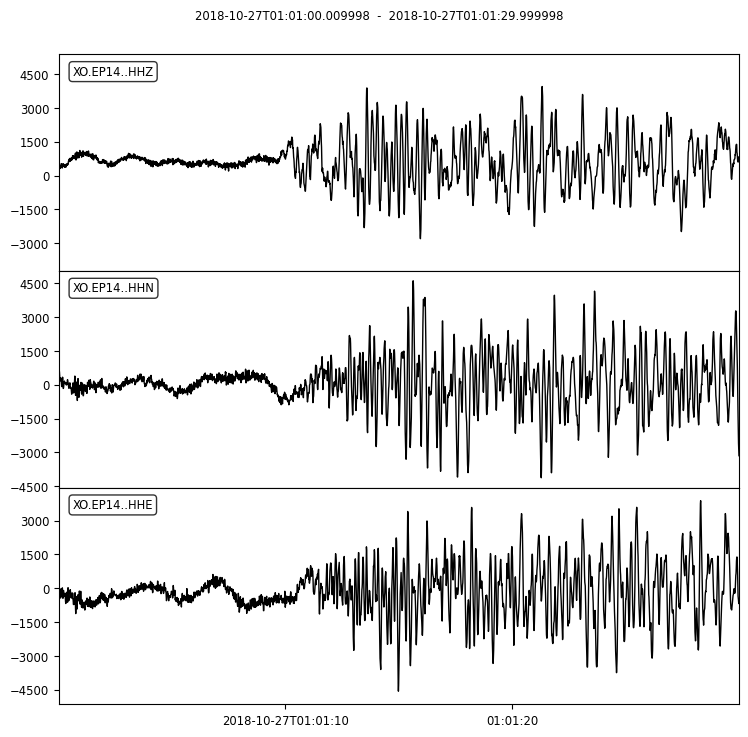

In [43]:
test[:3].plot();

In [44]:
def detrend_trace(stream):
    '''
    This operation is performed in place on the actual data arrays. The
    raw data will no longer be accessible afterwards. To keep your
    original data, use :meth:`~obspy.core.stream.Stream.copy` to create
    
    NOTE: promotes data to float64
    '''
    detrended = stream.detrend("spline", order=2, dspline=5 * stream[0].stats.sampling_rate)
    return detrended

In [45]:
detrend = detrend_trace(test[:3].copy())

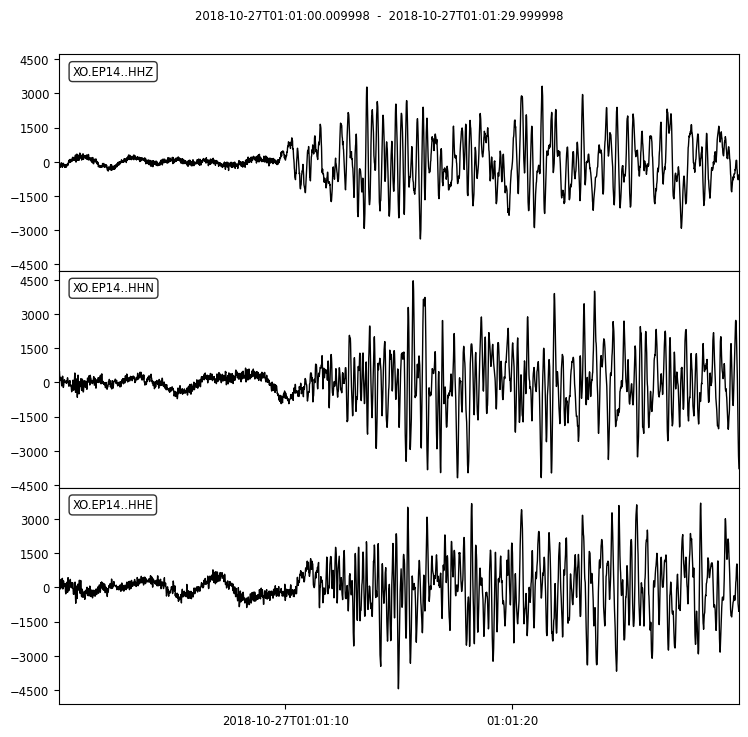

In [46]:
detrend.plot();

In [86]:
# NOTE: how does iris resample traces? shouldn't these be the same? seems for sub milisecond precision can't use same time index
#for trace in test:
#    print(trace.stats.starttime)
#2018-10-27T01:01:00.009998Z
#2018-10-27T01:01:00.009998Z
#2018-10-27T01:01:00.009998Z
#2018-10-27T01:01:00.000003Z
#2018-10-27T01:01:00.000003Z
#2018-10-27T01:01:00.000003Z
#2018-10-27T01:01:00.009998Z
#2018-10-27T01:01:00.009998Z
#2018-10-27T01:01:00.009998Z
#2018-10-27T01:01:00.000000Z
#2018-10-27T01:01:00.000000Z
#2018-10-27T01:01:00.000000Z

In [89]:
# How to save original traces locally?
test.write('stream.mseed', format='MSEED')

In [90]:
!ls -ltrh stream.mseed

-rw-r--r-- 1 jovyan users 2.0M Jan 20 00:52 stream.mseed


In [126]:
# Save traces to dataframe / parquet
single_stream = test[:3]
trace = single_stream[0]
index = pd.to_datetime(trace.times('timestamp'), unit='s')
df = pd.DataFrame(index=index)
for trace in single_stream:
    df[trace.id] = trace.data

In [127]:
df

,XO.EP14..HHE,XO.EP14..HHN,XO.EP14..HHZ
2018-10-27 01:01:00.009998080,-559,371,267
2018-10-27 01:01:00.019997952,-421,580,219
2018-10-27 01:01:00.029998080,-206,586,441
2018-10-27 01:01:00.039997952,-73,414,459
2018-10-27 01:01:00.049998080,-48,223,394
...,...,...,...
2018-10-27 01:01:29.959998208,-345,-1415,598
2018-10-27 01:01:29.969998080,-425,-2108,604
2018-10-27 01:01:29.979998208,-543,-2593,788
2018-10-27 01:01:29.989998080,-681,-2910,830


In [128]:
df.to_parquet('XO_EP14_HH.parquet', version='2.6')

In [47]:
#test.remove_response? # Deconvolve instrument response
#test.remove_sensitivity? # Difference?

In [48]:
residual = test[0].data - detrend[0].data

In [49]:
detrend[0].data.dtype

dtype('float64')

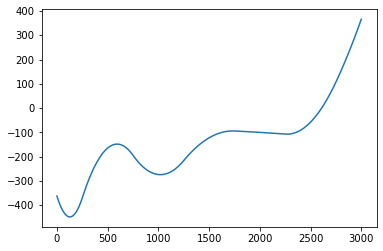

In [50]:
import matplotlib.pyplot as plt
plt.plot(residual)

In [171]:
def integrate_trace(trace):
    ''' operate in-place on stream, not a copy '''
    trace.integrate()
    trace.filter("highpass", freq=1.0)

In [135]:
def remove_response(trace, response):
    ''' just divide by response.instrument_sensitivity.value ? '''
    return trace / response

In [139]:
dfS.head()

,network,station,location,channel,seed_id,latitude,longitude,elevation,depth,azimuth,dip,sample_rate,start_date,end_date,response,units,name
0,XO,EP14,,HHE,XO.EP14..HHE,59.3257,-155.9036,56.0,0.0,90.0,0.0,100.0,2018-06-06 00:00:00,2019-12-31 23:59:59,503939000.0,m/s,XO.EP14..HH
1,XO,EP14,,HHN,XO.EP14..HHN,59.3257,-155.9036,56.0,0.0,0.0,0.0,100.0,2018-06-06 00:00:00,2019-12-31 23:59:59,503939000.0,m/s,XO.EP14..HH
2,XO,EP14,,HHZ,XO.EP14..HHZ,59.3257,-155.9036,56.0,0.0,0.0,-90.0,100.0,2018-06-06 00:00:00,2019-12-31 23:59:59,503939000.0,m/s,XO.EP14..HH
3,XO,EP15,,HHE,XO.EP15..HHE,58.9664,-155.0867,249.0,0.0,90.0,0.0,100.0,2018-06-10 12:00:00,2019-12-31 23:59:59,503939000.0,m/s,XO.EP15..HH
4,XO,EP15,,HHN,XO.EP15..HHN,58.9664,-155.0867,249.0,0.0,0.0,0.0,100.0,2018-06-10 12:00:00,2019-12-31 23:59:59,503939000.0,m/s,XO.EP15..HH


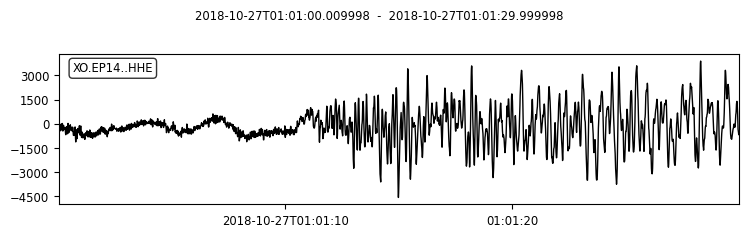

In [144]:
# 427993.0	m/s**2	XO.WS75..HN
# 503939000.0	m/s	XO.EP14..HH
#test.select(station='EP14')
test.select(id='XO.EP14..HHE').plot();

In [149]:
type(test.select(id='XO.EP14..HHE')[0])

obspy.core.trace.Trace

In [155]:
# Is instrument response always the same across channels?

normalized = remove_response(test.select(id='XO.EP14..HHE')[0].data, 503939000.0) 
normalized

array([ -1.10926124e-06,  -8.35418572e-07,  -4.08779634e-07, ...,
        -1.07751137e-06,  -1.35135403e-06,  -1.09735504e-06])

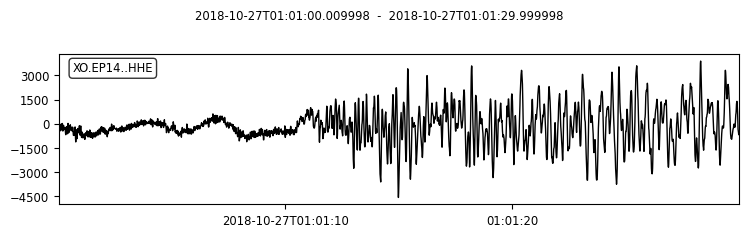

In [162]:
trace = test.select(id='XO.EP14..HHE') #NOTE: makes a copy? NO.
trace.plot();

In [165]:
trace[0].data = normalized

In [166]:
trace[0].data

array([ -1.10926124e-06,  -8.35418572e-07,  -4.08779634e-07, ...,
        -1.07751137e-06,  -1.35135403e-06,  -1.09735504e-06])

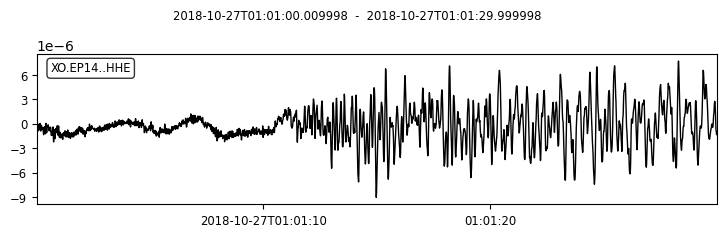

In [168]:
trace.plot();

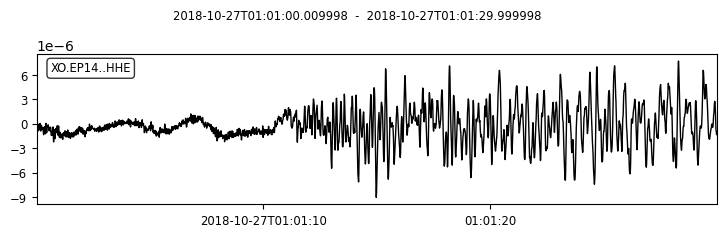

In [172]:
test.select(id='XO.EP14..HHE').plot();

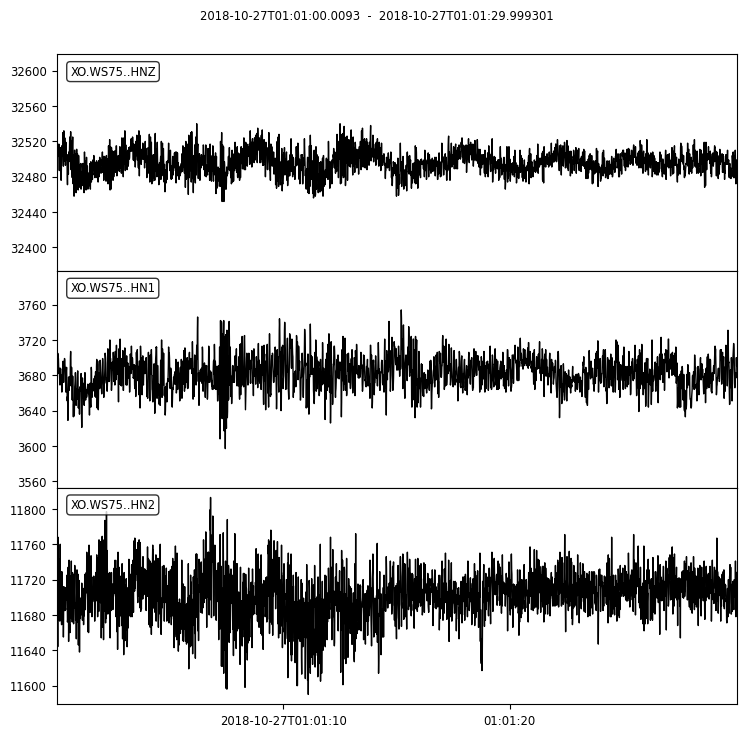

In [175]:
test.select(id='XO.WS75..HN*').plot();

In [177]:
integrate_trace(test.select(id='XO.WS75..HN*'))

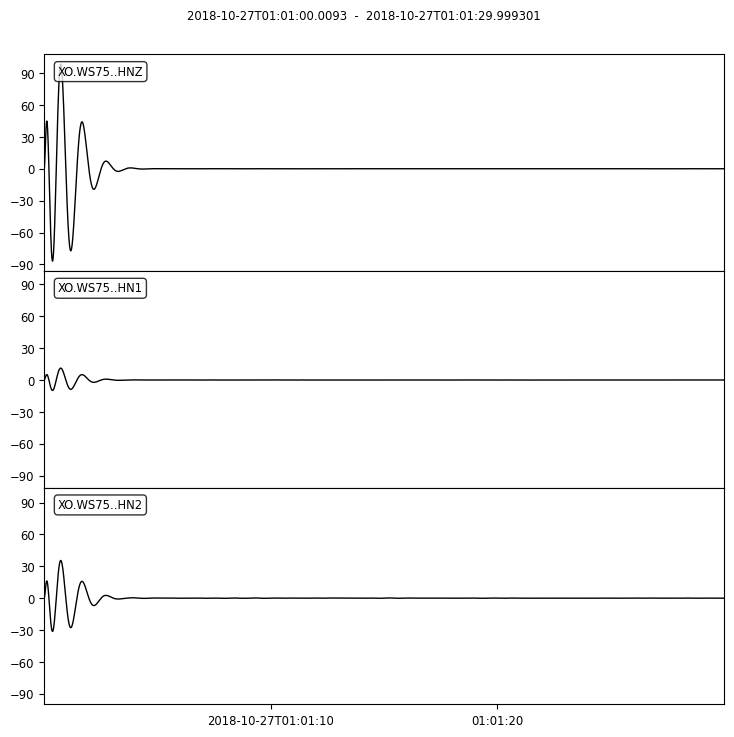

In [178]:
test.select(id='XO.WS75..HN*').plot();

## Run phasenet

In [ ]:
def obspy2phasenet():

In [ ]:
PHASENET_API_URL = "http://phasenet.quakeflow.com"
config = {}
config["xlim_degree"] = [-170,-140]
config["ylim_degree"] = [50,65]
stations_json = station_locs.to_dict(orient="records")
config_gamma = {'xlim_degree': config["xlim_degree"], 
                'ylim_degree': config["ylim_degree"],
                'z(km)': [0, 41]}